In [1]:
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
import argparse
import datetime
import json
import random
import time
from pathlib import Path
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, DistributedSampler

import datasets
import models.deit_models
import util.misc as utils
from datasets import build_dataset, get_coco_api_from_dataset
from engine import evaluate, train_one_epoch
from models import build_model
from models.pytorch_pretrained_vit.configs import PRETRAINED_MODELS
from models.pytorch_pretrained_vit.utils import resize_positional_embedding_, maybe_print
from tensorboardX import SummaryWriter

torch.multiprocessing.set_sharing_strategy('file_system')
import resource
rlimit = resource.getrlimit(resource.RLIMIT_NOFILE)
resource.setrlimit(resource.RLIMIT_NOFILE, (4096, rlimit[1]))
#import wandb
from argparse import Namespace

%load_ext autoreload
%autoreload 2

## Parse Argument

In [2]:
def get_args_parser():
    parser = argparse.ArgumentParser('Set transformer detector', add_help=False)

    # Transformed Detection Args
    parser.add_argument('--experiment_name', default='train', type=str)
    parser.add_argument('--overfit_one_batch', default=False, action='store_true')
    parser.add_argument('--pretrained_vit', default=False, action='store_true')
    parser.add_argument('--pretrained_model', default='B_16_imagenet1k', type=str,
                        help="ViT pre-trained model type")
    parser.add_argument('--pretrain_dir', default='/nfs/data3/koner/data/checkpoints/vit_detr/B_16_imagenet1k.pth',
                        help='path to load wight of pre train classification')
    parser.add_argument('--detr_pretrain_dir', default='',
                        help='path to load wight of pre train classification')
    parser.add_argument('--random_image_size', default=False, action='store_true')
    parser.add_argument('--img_width', default=384, type=int)
    parser.add_argument('--img_height', default=384, type=int)
    parser.add_argument('--data_width', default=560, type=int)
    parser.add_argument('--data_height', default=560, type=int)
    parser.add_argument('--backbone_nheads', default=12, type=int,
                        help="Number of attention heads inside the transformer's attentions")
    parser.add_argument('--detr_nheads', default=8, type=int,
                        help="Number of attention heads inside the transformer's attentions")
    parser.add_argument('--enc_layers', default=12, type=int,
                        help="Number of encoding layers in the transformer")
    parser.add_argument('--include_class_token', default=False, action='store_true')
    parser.add_argument("--skip_connection", nargs="*", type=int, default=list(range(0,12)), help="list of index where skip conn will be made")
    # parser.add_argument('--skip_connection', default=False, action='store_true')
    parser.add_argument('--hierarchy', default=False, action='store_true')
    parser.add_argument('--only_weight', action='store_true', help='used for coco trainined detector')
    parser.add_argument('--pool', default='max', type=str, choices=('max', 'avg'))
    parser.add_argument('--small_augment', default=False, action='store_true')
    parser.add_argument('--mixed_augment', default=False, action='store_true')
    parser.add_argument('--opt', default='AdamW', type=str, choices=('AdamW', 'SGD'))
    parser.add_argument('--drop_path', type=float, default=0., metavar='PCT',
                        help='Drop path rate (default: 0.)')
    parser.add_argument('--print_details', default=False, action='store_true')
    parser.add_argument("--cuda_visible_device", nargs="*", type=int, default=None,
                        help="list of index where skip conn will be made")

    # Training
    parser.add_argument('--lr', default=2e-4, type=float)
    parser.add_argument('--lr_backbone', default=1e-5, type=float)
    parser.add_argument('--batch_size', default=2, type=int)
    parser.add_argument('--weight_decay', default=1e-4, type=float)
    parser.add_argument('--epochs', default=300, type=int)
    parser.add_argument('--lr_drop', default=200, type=int)
    parser.add_argument('--print_freq', default=500000, type=int)
    parser.add_argument('--clip_max_norm', default=0.1, type=float,
                        help='gradient clipping max norm')

    # Model parameters
    parser.add_argument('--frozen_weights', type=str, default=None,
                        help="Path to the pretrained model. If set, only the mask head will be trained")
    # * Backbone
    parser.add_argument('--backbone', default='ViT', type=str,choices=('ViT','Deit'),
                        help="Name of the convolutional backbone to use")
    parser.add_argument('--dilation', action='store_true',
                        help="If true, we replace stride with dilation in the last convolutional block (DC5)")
    parser.add_argument('--position_embedding', default='1d', type=str,
                        choices=('1d', '2d', 'sine', 'learned'),
                        help="Type of positional embedding to use on top of the image features")
    parser.add_argument('--reduce_feature', default=False, action='store_true')

    # * Transformer
    parser.add_argument('--dec_layers', default=6, type=int,
                        help="Number of decoding layers in the transformer")
    parser.add_argument('--dim_feedforward', default=2048, type=int,
                        help="Intermediate size of the feedforward layers in the transformer blocks")
    parser.add_argument('--hidden_dim', default=768, type=int,
                        help="Size of the embeddings (dimension of the transformer)")
    parser.add_argument('--dropout', default=0.1, type=float,
                        help="Dropout applied in the transformer")
    parser.add_argument('--num_queries', default=100, type=int,
                        help="Number of query slots")
    parser.add_argument('--pre_norm', action='store_true')
    parser.add_argument('--cross_first', action='store_true', help='apply corss attn then self attn on decoder')

    # * Segmentation
    parser.add_argument('--masks', action='store_true',
                        help="Train segmentation head if the flag is provided")

    # Loss
    parser.add_argument('--no_aux_loss', dest='aux_loss', action='store_false',
                        help="Disables auxiliary decoding losses (loss at each layer)")
    # * Matcher
    parser.add_argument('--set_cost_class', default=1, type=float,
                        help="Class coefficient in the matching cost")
    parser.add_argument('--set_cost_bbox', default=5, type=float,
                        help="L1 box coefficient in the matching cost")
    parser.add_argument('--set_cost_giou', default=2, type=float,
                        help="giou box coefficient in the matching cost")
    # * Loss coefficients
    parser.add_argument('--mask_loss_coef', default=1, type=float)
    parser.add_argument('--dice_loss_coef', default=1, type=float)
    parser.add_argument('--bbox_loss_coef', default=5, type=float)
    parser.add_argument('--giou_loss_coef', default=2, type=float)
    parser.add_argument('--eos_coef', default=0.1, type=float,
                        help="Relative classification weight of the no-object class")

    # dataset parameters
    parser.add_argument('--dataset_file', default='coco')
    parser.add_argument('--coco_path', type=str)
    parser.add_argument('--coco_panoptic_path', type=str)
    parser.add_argument('--remove_difficult', action='store_true')


    parser.add_argument('--output_dir', default='',
                        help='path where to save, empty for no saving')

    parser.add_argument('--device', default='cuda',
                        help='device to use for training / testing')
    parser.add_argument('--seed', default=42, type=int)
    parser.add_argument('--resume', default='', help='resume from checkpoint')
    parser.add_argument('--start_epoch', default=0, type=int, metavar='N',
                        help='start epoch')
    parser.add_argument('--eval', action='store_true')
    parser.add_argument('--num_workers', default=2, type=int)

    # distributed training parameters
    parser.add_argument('--world_size', default=1, type=int,
                        help='number of distributed processes')
    parser.add_argument('--dist_url', default='env://',
                        help='url used to set up distributed training')


    return parser

In [3]:
parser = argparse.ArgumentParser('DETR training and evaluation script',
                                     parents=[get_args_parser()])
terminal_arg = "--coco_path /mnt/Drive1/supro/mscoco/ --pretrained_model deit_base_patch16_384 --pretrain_dir /mnt/Drive1/supro/vit_detr/deit_base_patch16_384-8de9b5d1.pth --num_workers 0 --experiment_name test_height_width --batch_size 32 --position_embedding 1d --data_width 576 --data_height 768 --img_width 768 --img_height 576 --print_freq 700 --pretrained_vit --lr_backbone 1e-4 --lr 1e-4 --opt AdamW --skip_connection 2 5 8 --backbone Deit --cuda_visible_device 1 --mixed_augment --small_augment"
args = parser.parse_args(terminal_arg.split())
args.img_size = (args.img_height, args.img_width)
# args.data_size = (args.data_height, args.data_width)
print(args)
if not args.output_dir:  #create output dir as per experiment name
    args.output_dir = './' + args.experiment_name
Path(args.output_dir).mkdir(parents=True, exist_ok=True)

Namespace(aux_loss=True, backbone='Deit', backbone_nheads=12, batch_size=32, bbox_loss_coef=5, clip_max_norm=0.1, coco_panoptic_path=None, coco_path='/mnt/Drive1/supro/mscoco/', cross_first=False, cuda_visible_device=[1], data_height=768, data_width=576, dataset_file='coco', dec_layers=6, detr_nheads=8, detr_pretrain_dir='', device='cuda', dice_loss_coef=1, dilation=False, dim_feedforward=2048, dist_url='env://', drop_path=0.0, dropout=0.1, enc_layers=12, eos_coef=0.1, epochs=300, eval=False, experiment_name='test_height_width', frozen_weights=None, giou_loss_coef=2, hidden_dim=768, hierarchy=False, img_height=576, img_size=(576, 768), img_width=768, include_class_token=False, lr=0.0001, lr_backbone=0.0001, lr_drop=200, mask_loss_coef=1, masks=False, mixed_augment=True, num_queries=100, num_workers=0, only_weight=False, opt='AdamW', output_dir='', overfit_one_batch=False, pool='max', position_embedding='1d', pre_norm=False, pretrain_dir='/mnt/Drive1/supro/vit_detr/deit_base_patch16_384

## Debug Model

In [4]:
# # wandb.login()
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# utils.init_distributed_mode(args)
# print("git:\n  {}\n".format(utils.get_sha()))

# if args.frozen_weights is not None:
#     assert args.masks, "Frozen training is meant for segmentation only"
# device = torch.device(args.device)

# # fix the seed for reproducibility
# seed = args.seed + utils.get_rank()
# torch.manual_seed(seed)
# np.random.seed(seed)
# random.seed(seed)
# model, criterion, postprocessors = build_model(args)
# model.to(device)

# model_without_ddp = model
# if args.distributed:
#     model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[args.gpu],
#                                                       find_unused_parameters=True)
#     model_without_ddp = model.module
# n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print('number of params:', n_parameters)

## Debug Dataloader

In [4]:
def plot_coco_sample(image, bboxes, labels, relative_coords=True):
    H, W = image.shape[0], image.shape[1]
    fig, ax = plt.subplots(dpi=160)

    # Displaying the image
    ax.imshow(image)

    # Bounding boxes
    for bbox, label in zip(bboxes, labels):
        l, t, r, b = bbox * [W, H, W, H] if relative_coords else bbox
        rect = patches.Rectangle((l, t), width=(r - l), height=(b - t),
                                 linewidth=1, edgecolor='#76b900', facecolor='none')
        ax.add_patch(rect)

    plt.show()

In [ ]:
seed = args.seed + utils.get_rank()
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
dataset_train = build_dataset(image_set='train', args=args)

dataset_val = build_dataset(image_set='val', args=args)
sampler_train = torch.utils.data.RandomSampler(dataset_train)
sampler_val = torch.utils.data.SequentialSampler(dataset_val)

batch_sampler_train = torch.utils.data.BatchSampler(
sampler_train, args.batch_size, drop_last=True)

data_loader_train = DataLoader(dataset_train, batch_sampler=batch_sampler_train,
                               collate_fn=utils.collate_fn, num_workers=args.num_workers,pin_memory=True)
data_loader_val = DataLoader(dataset_val, args.batch_size, sampler=sampler_val,
                             drop_last=False, collate_fn=utils.collate_fn,
                             num_workers=args.num_workers,pin_memory=True)

for samples, targets in data_loader_train:
    images = samples.tensors.data.cpu().numpy()
    bbox = targets[0]['boxes'].data.cpu().numpy()
    label = targets[0]['labels'].data.cpu().numpy()
#     from models.pytorch_pretrained_vit.utils import plot_coco_sample
#     plot_coco_sample(images[0,0,...], bbox, label)

loading annotations into memory...
Done (t=12.76s)
creating index...
index created!
loading annotations into memory...
Done (t=1.69s)
creating index...
index created!


## Debug Main

Not using distributed mode
git:
  sha: ca9fc9da7e52a55aa2776ac400ee7f6798d0c519, status: has uncommited changes, branch: spatial_aug

Loading weightfrom: /mnt/Drive1/supro/vit_detr/deit_base_patch16_384-8de9b5d1.pth
torch.Size([1, 1729, 768])
Resized positional embeddings from torch.Size([1, 577, 768]) to torch.Size([1, 1729, 768])
torch.Size([1, 1729, 768])
Missing keys when loading pretrained weights: ['red_feat.weight', 'red_feat.bias']
Unexpected keys when loading pretrained weights: []
number of params: 138704968
Train with AdamW
loading annotations into memory...
Done (t=12.48s)
creating index...
index created!
loading annotations into memory...
Done (t=0.37s)
creating index...
index created!
Start training
epoch:0
> /home/supro/projects/transformed_detr/engine.py(32)train_one_epoch()
     30         import pdb
     31         pdb.set_trace()
---> 32         outputs = model(samples)
     33         loss_dict = criterion(outputs, targets)
     34         weight_dict = criterion.we

ipdb>  from models.pytorch_pretrained_vit.utils import plot_coco_sample
ipdb>  images = samples.tensors.data.cpu().numpy()
ipdb>  images.shape


(10, 3, 576, 768)


ipdb>  bbox = targets[0]['boxes'].data.cpu().numpy()
ipdb>  label = targets[0]['labels'].data.cpu().numpy()
ipdb>  plot_coco_sample(images[0,0,...], bbox, label)


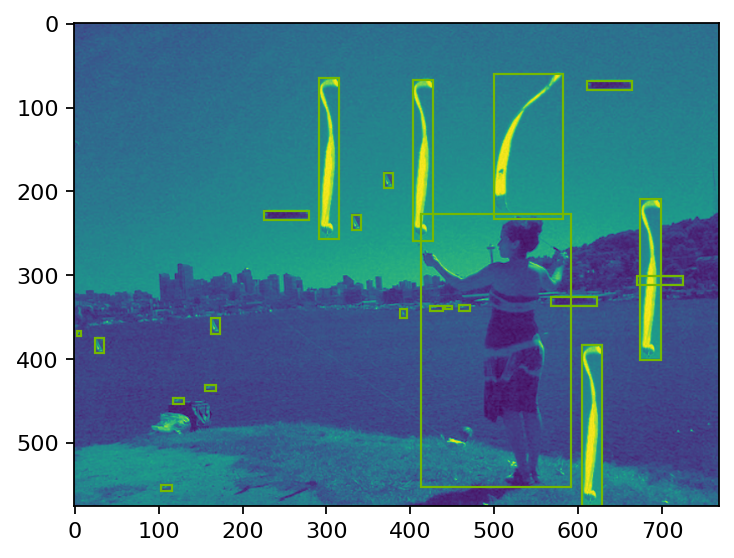

ipdb>  bbox = targets[1]['boxes'].data.cpu().numpy()
ipdb>  label = targets[1]['labels'].data.cpu().numpy()
ipdb>  plot_coco_sample(images[1,0,...], bbox, label)


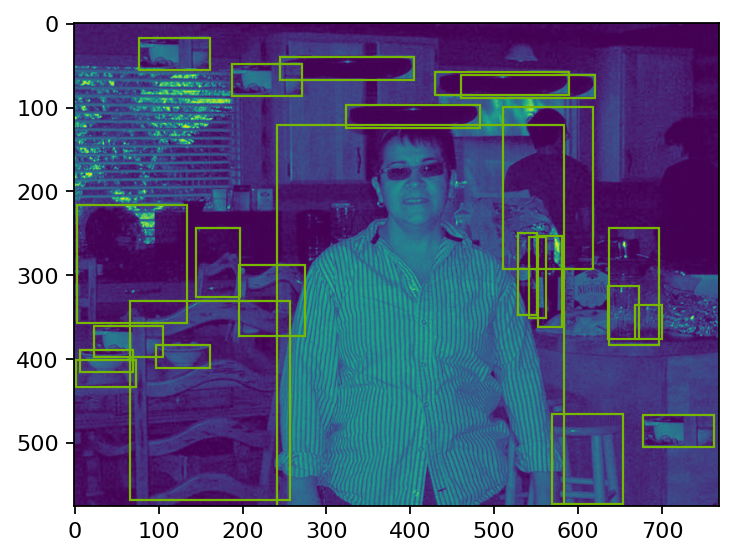

ipdb>  continue


RuntimeError: CUDA out of memory. Tried to allocate 1.34 GiB (GPU 0; 47.46 GiB total capacity; 45.42 GiB already allocated; 276.44 MiB free; 46.07 GiB reserved in total by PyTorch)

In [4]:
#os.environ["CUDA_VISIBLE_DEVICES"] = '0,1'
# wandb.login()
if args.cuda_visible_device is not None:
    os.environ["CUDA_VISIBLE_DEVICES"] = ','.join(map(str, args.cuda_visible_device))
utils.init_distributed_mode(args)
print("git:\n  {}\n".format(utils.get_sha()))

if args.frozen_weights is not None:
    assert args.masks, "Frozen training is meant for segmentation only"
device = torch.device(args.device)

# fix the seed for reproducibility
seed = args.seed + utils.get_rank()
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

model, criterion, postprocessors = build_model(args)

model.to(device)

model_without_ddp = model
if args.distributed:
    model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[args.gpu],
                                                      find_unused_parameters=True)
    model_without_ddp = model.module
n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('number of params:', n_parameters)

param_dicts = [
    {"params": [p for n, p in model_without_ddp.named_parameters() if
                "backbone" not in n and p.requires_grad]},
    {
        "params": [p for n, p in model_without_ddp.named_parameters() if
                   "backbone" in n and p.requires_grad],
        "lr": args.lr_backbone,
    },
]
if args.opt=="AdamW":
    print("Train with AdamW")
    optimizer = torch.optim.AdamW(param_dicts, lr=args.lr,
                                  weight_decay=args.weight_decay)
else:
    print("Train with SGD")
    optimizer = torch.optim.SGD(param_dicts, lr=args.lr, weight_decay=args.weight_decay)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, args.lr_drop)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5, factor=0.8,
                               verbose=True, threshold=0.001, threshold_mode='abs', cooldown=1)

dataset_train = build_dataset(image_set='train', args=args)

dataset_val = build_dataset(image_set='val', args=args)

if args.distributed:
    num_tasks = utils.get_world_size()
    global_rank = utils.get_rank()
    sampler_train = DistributedSampler(dataset_train, num_replicas=num_tasks, rank=global_rank)
    sampler_val = DistributedSampler(dataset_val, num_replicas=num_tasks, rank=global_rank, shuffle=False)
else:
    sampler_train = torch.utils.data.RandomSampler(dataset_train)
    sampler_val = torch.utils.data.SequentialSampler(dataset_val)

batch_sampler_train = torch.utils.data.BatchSampler(
    sampler_train, args.batch_size, drop_last=True)

data_loader_train = DataLoader(dataset_train, batch_sampler=batch_sampler_train,
                               collate_fn=utils.collate_fn, num_workers=args.num_workers,pin_memory=True)
data_loader_val = DataLoader(dataset_val, args.batch_size, sampler=sampler_val,
                             drop_last=False, collate_fn=utils.collate_fn,
                             num_workers=args.num_workers,pin_memory=True)

if args.dataset_file == "coco_panoptic":
    # We also evaluate AP during panoptic training, on original coco DS
    coco_val = datasets.coco.build("val", args)
    base_ds = get_coco_api_from_dataset(coco_val)
else:
    base_ds = get_coco_api_from_dataset(dataset_val)

if args.frozen_weights is not None:
    checkpoint = torch.load(args.frozen_weights, map_location='cpu')
    model_without_ddp.detr.load_state_dict(checkpoint['model'])

output_dir = Path(args.output_dir)
if args.resume:
    if args.resume.startswith('https'):
        checkpoint = torch.hub.load_state_dict_from_url(
            args.resume, map_location='cpu', check_hash=True)
    else:
        checkpoint = torch.load(args.resume, map_location='cpu')
    # If we want to transfer learn on new image size, we need to resize positional embedding of ViT
    if args.img_size != (checkpoint['args'].img_width, checkpoint['args'].img_height):
        old_img = (checkpoint['args'].img_width // model_without_ddp.backbone.patch_embed.patch_size[0],
                   checkpoint['args'].img_height // model_without_ddp.backbone.patch_embed.patch_size[1])
        new_img = (args.img_size[0] // model_without_ddp.backbone.patch_embed.patch_size[0],
                   args.img_size[1] // model_without_ddp.backbone.patch_embed.patch_size[1])
        posemb = checkpoint['model']['backbone.pos_embed']
        posemb_new = model_without_ddp.state_dict()['backbone.pos_embed']
        checkpoint['model']['backbone.pos_embed'] = \
            resize_positional_embedding_(posemb=posemb, posemb_new=posemb_new,
                                         has_class_token=hasattr(model_without_ddp.backbone, 'cls_token'),
                                         # todo cls token remon
                                         gs_old=old_img, gs_new=new_img)  # todo mayb not old img [0]
        maybe_print('Resized positional embeddings from {} to {}'.format(
            posemb.shape, posemb_new.shape), True)
    print('Resumming Model from:', args.resume)
    ret = model_without_ddp.load_state_dict(checkpoint['model'], strict=False)
    maybe_print('Missing keys when loading pretrained weights: {}'.format(ret.missing_keys), True)
    maybe_print('Unexpected keys when loading pretrained weights: {}'.format(ret.unexpected_keys), True)
    if not args.eval and 'optimizer' in checkpoint and 'lr_scheduler' in checkpoint and 'epoch' in checkpoint and not args.only_weight:
        print('Resumming Optimizer from:', args.resume)
        optimizer.load_state_dict(checkpoint['optimizer'])
        lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
        args.start_epoch = checkpoint['epoch'] + 1

if args.eval:
    test_stats, coco_evaluator = evaluate(model, criterion, postprocessors,
                                          data_loader_val, base_ds, device, args.output_dir)
    if args.output_dir:
        utils.save_on_master(coco_evaluator.coco_eval["bbox"].eval, output_dir / "eval.pth")

# Create tensorboard writer
if os.environ.get("RANK", "0") == "0":
    writer = SummaryWriter(comment=args.experiment_name)

# tell wandb to get started
# if os.environ.get("RANK", "0") == "0":
#     wandb.init(project=args.experiment_name, config=args, dir="../")

print("Start training")
# tell wandb to watch what the model gets up to: gradients, weights, and more!
# if os.environ.get("RANK", "0") == "0":
#     wandb.watch(model, criterion, log="all", log_freq=10)
start_time = time.time()
for epoch in range(args.start_epoch, args.epochs):
    print(f"epoch:{epoch}")
    if args.distributed:
        sampler_train.set_epoch(epoch)
    train_stats = train_one_epoch(
        model, criterion, data_loader_train, optimizer, device, epoch,
        args.clip_max_norm, args.overfit_one_batch, args.print_freq, args.print_details)

In [ ]:
images = samples.tensors.data.cpu().numpy()
bbox = targets[0]['boxes'].data.cpu().numpy()
label = targets[0]['labels'].data.cpu().numpy()
from models.pytorch_pretrained_vit.utils import plot_coco_sample
plot_coco_sample(images[0,0,...], bbox, label)

## Plot Weights and Bias

In [1]:
weights_path = '/home/koner/transformed_detr/exp/skip_connection_wdNorm/B_16_imagenet1k.pth'
state_dict = torch.load(weights_path)

In [32]:
parameter = ['transformer.blocks.0.attn.proj_q.weight', 'transformer.blocks.0.attn.proj_q.bias', 'transformer.blocks.0.attn.proj_k.weight', 'transformer.blocks.0.attn.proj_k.bias', 'transformer.blocks.0.attn.proj_v.weight', 'transformer.blocks.0.attn.proj_v.bias', 'transformer.blocks.0.proj.weight', 'transformer.blocks.0.proj.bias', 'transformer.blocks.0.norm1.weight', 'transformer.blocks.0.norm1.bias', 'transformer.blocks.0.pwff.fc1.weight', 'transformer.blocks.0.pwff.fc1.bias', 'transformer.blocks.0.pwff.fc2.weight', 'transformer.blocks.0.pwff.fc2.bias', 'transformer.blocks.0.norm2.weight', 'transformer.blocks.0.norm2.bias']

In [41]:
state_dict['transformer.blocks.0.attn.proj_q.weight'].numpy().shape

(768, 768)

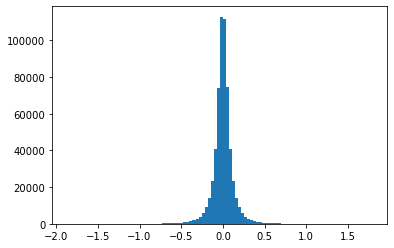

In [51]:
plt.hist(state_dict['transformer.blocks.0.attn.proj_q.weight'].numpy().flatten(), bins = 100)
plt.show()

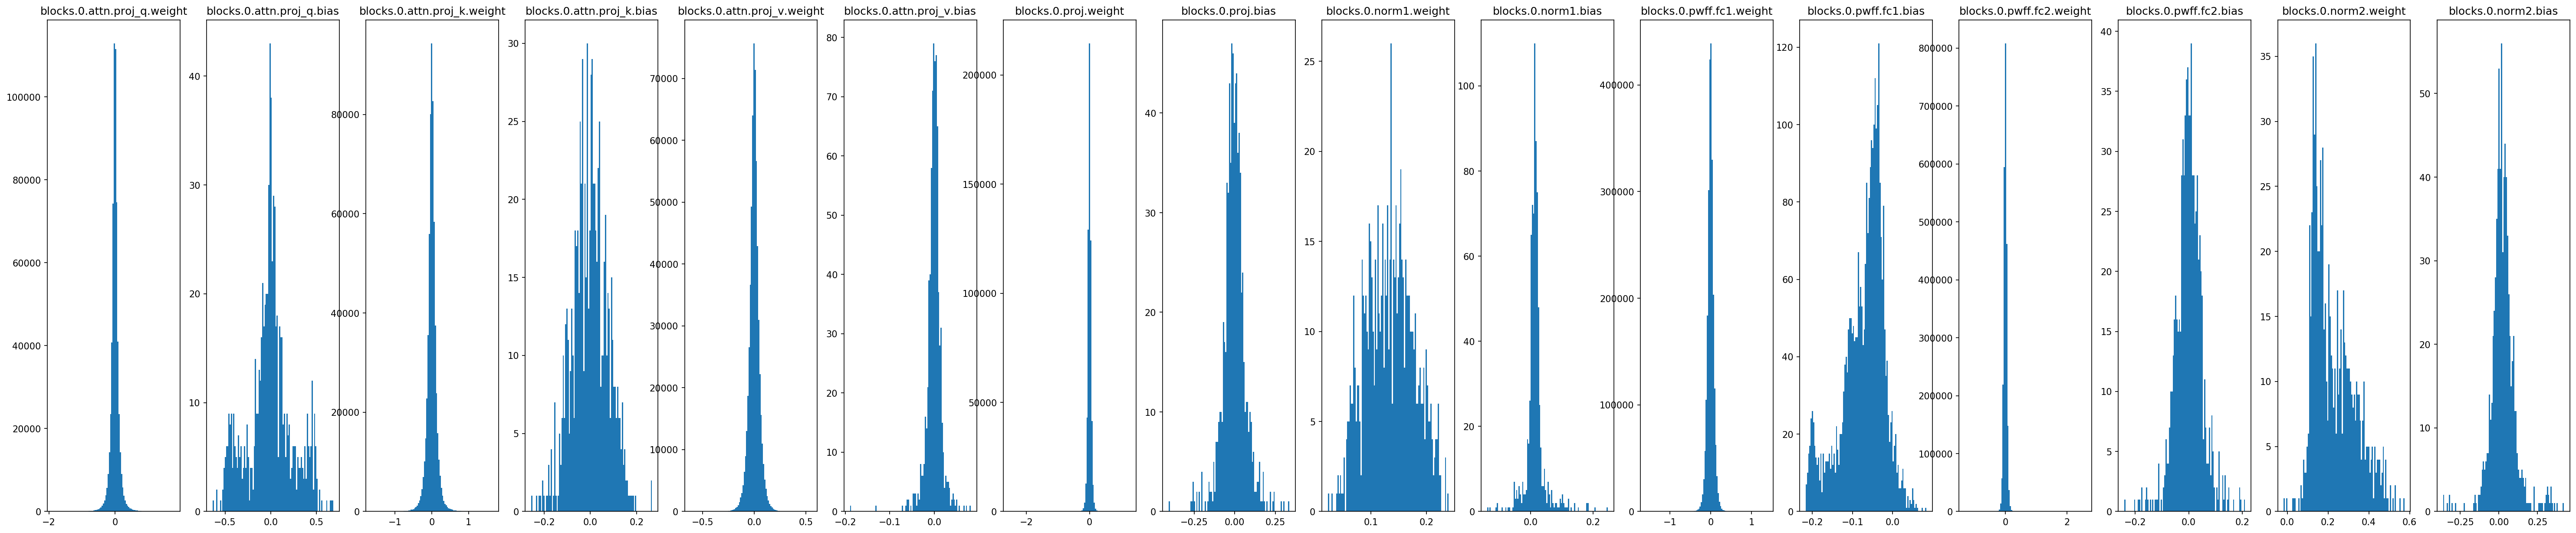

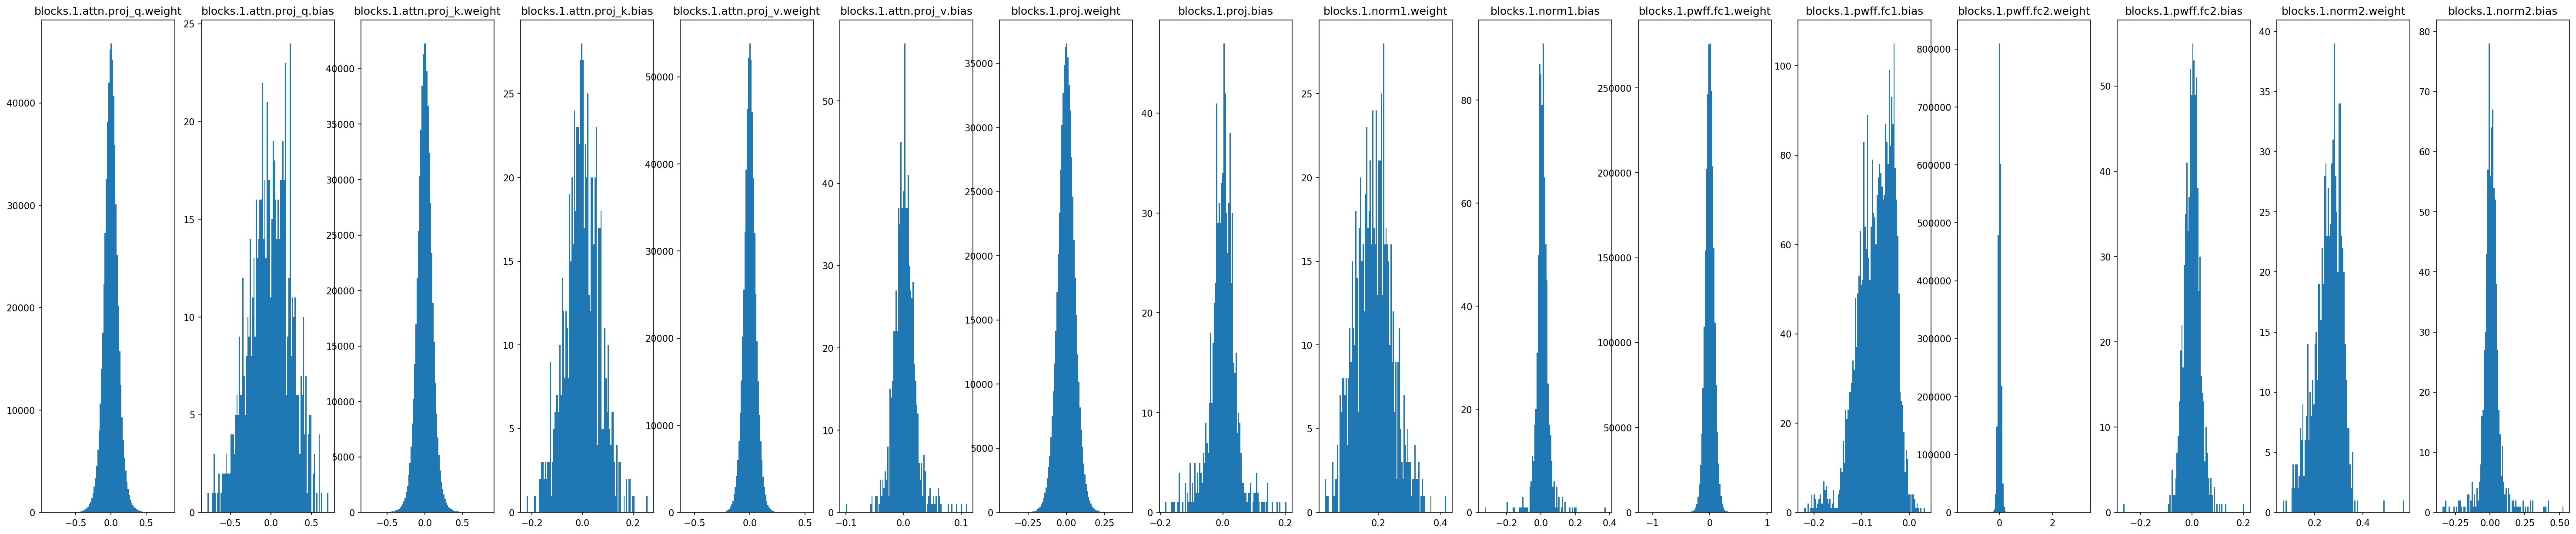

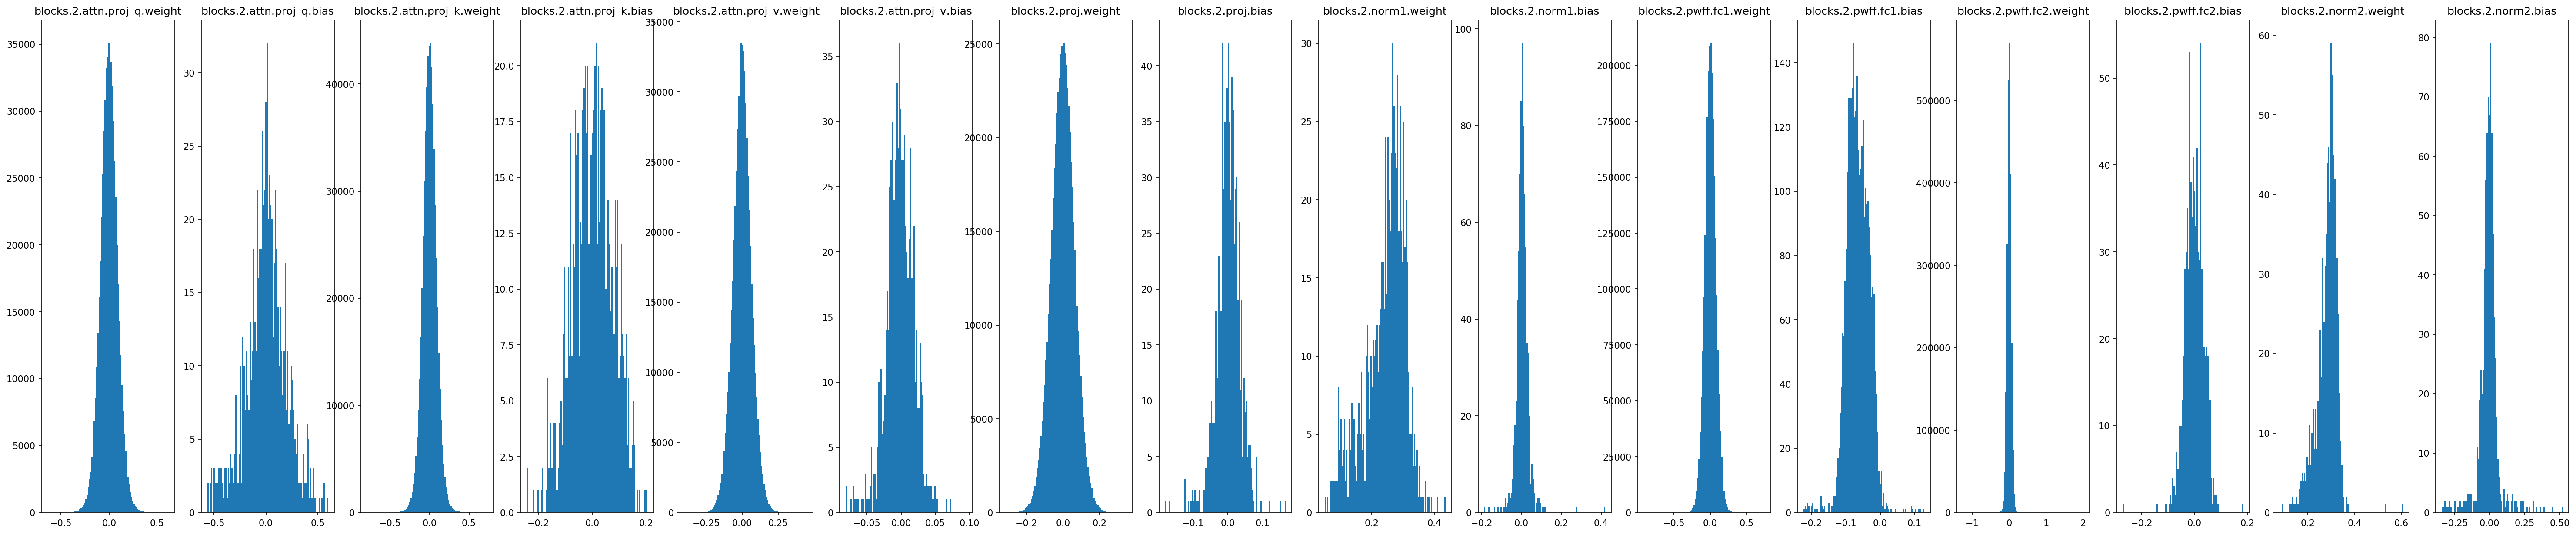

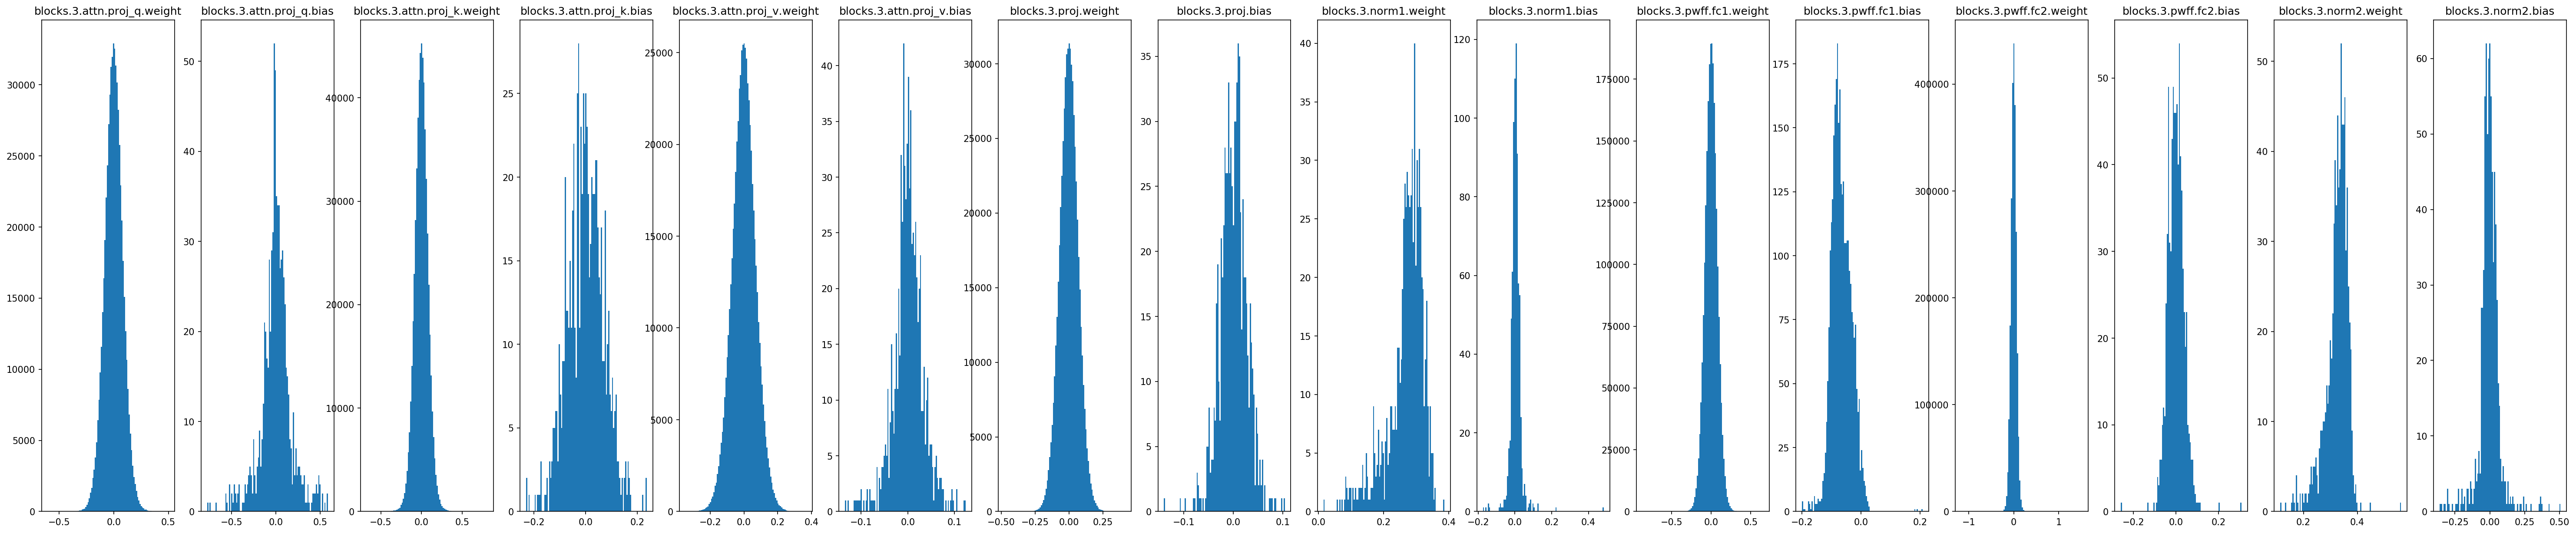

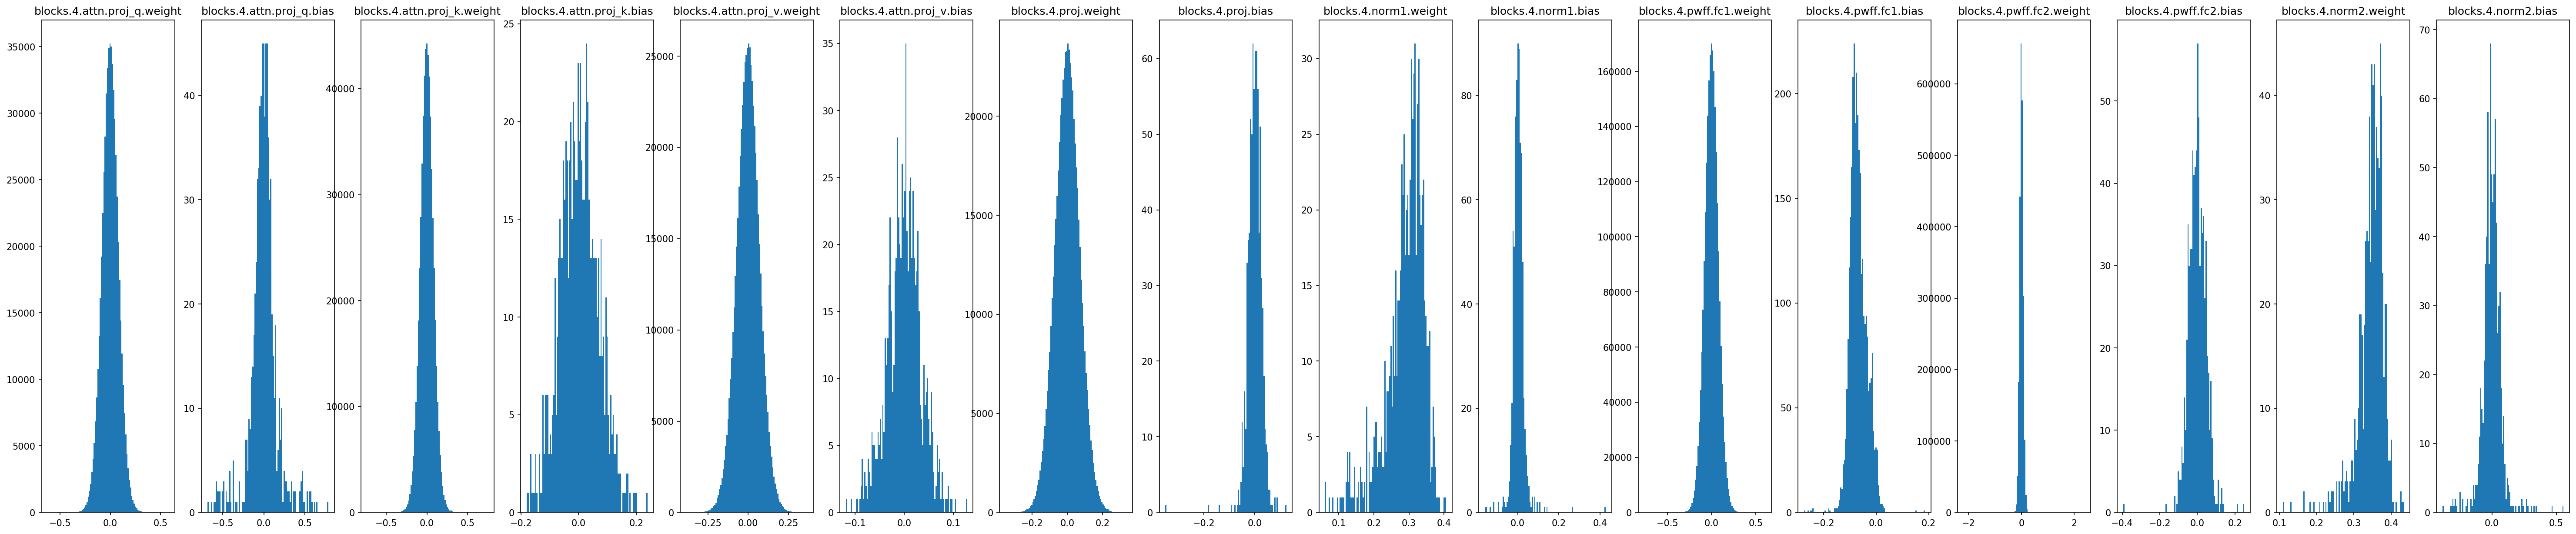

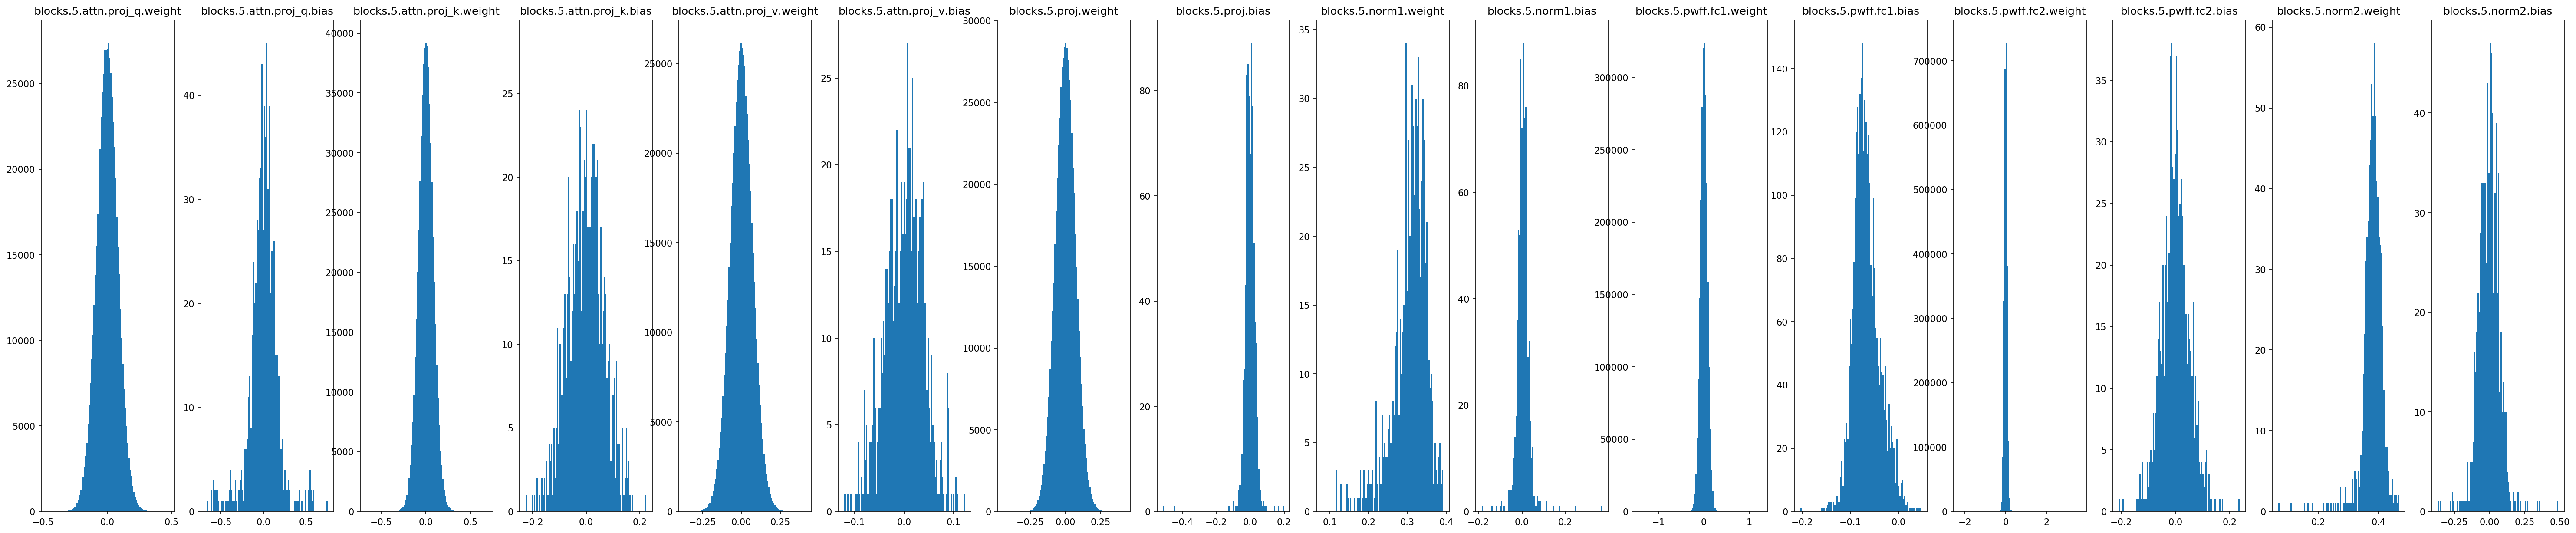

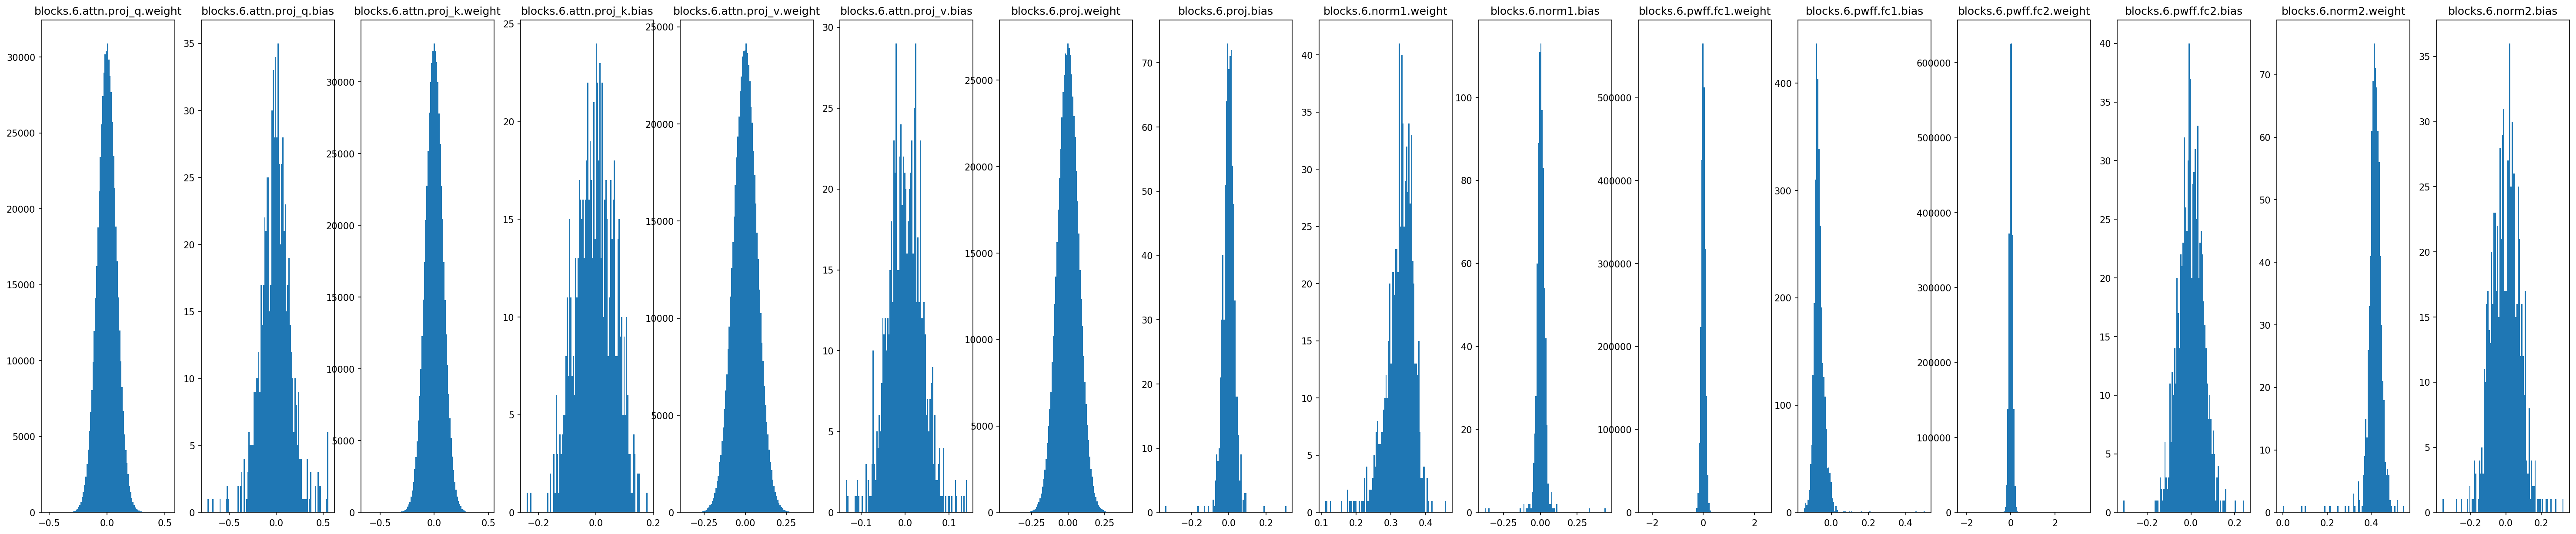

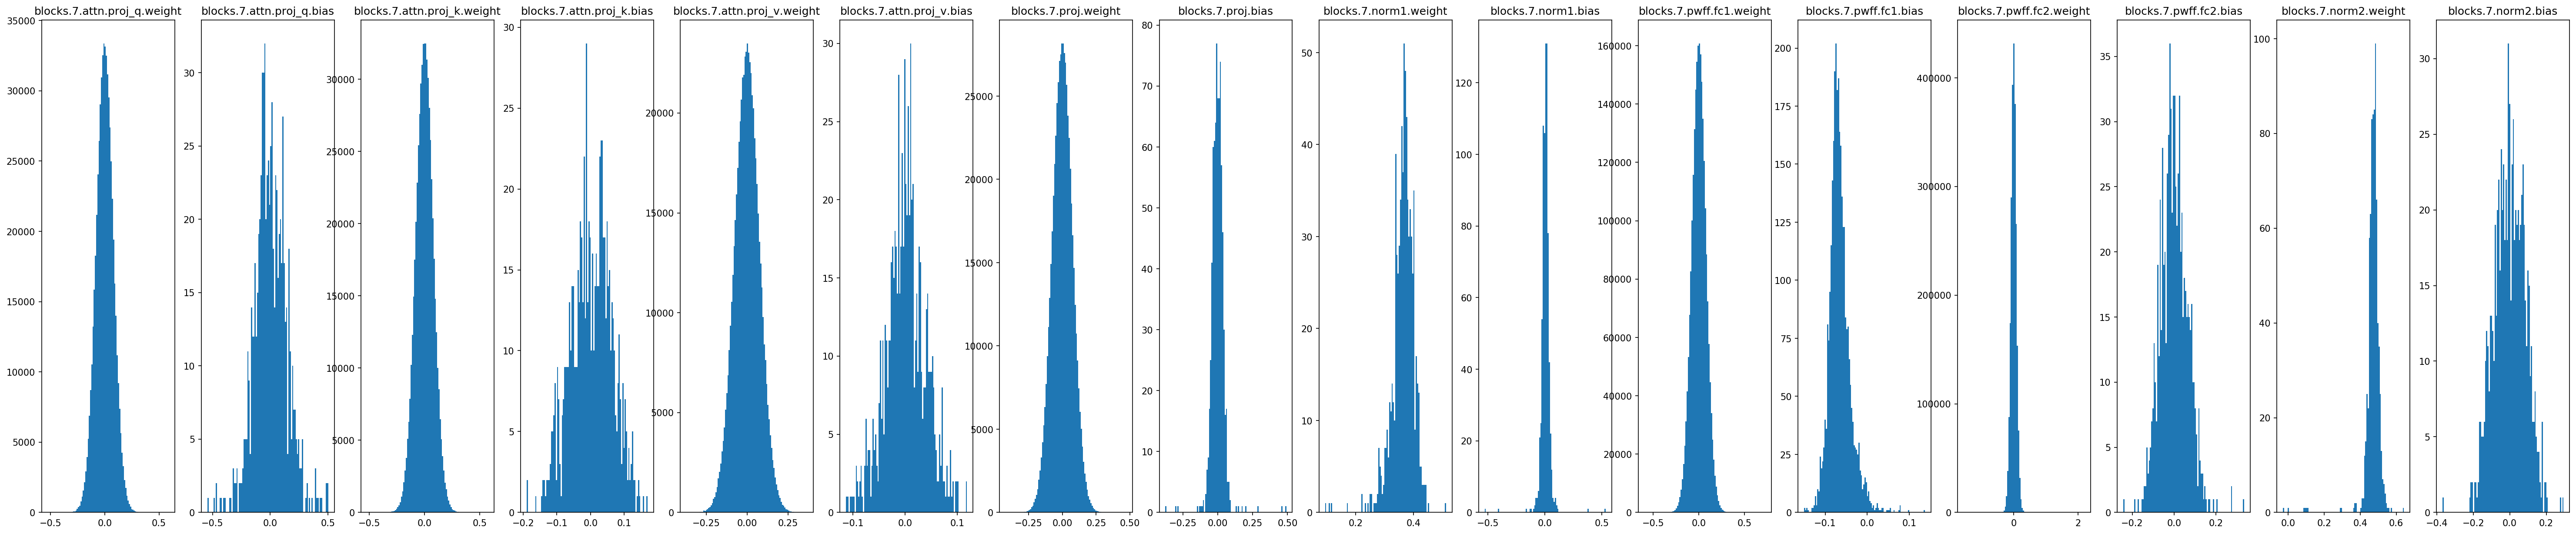

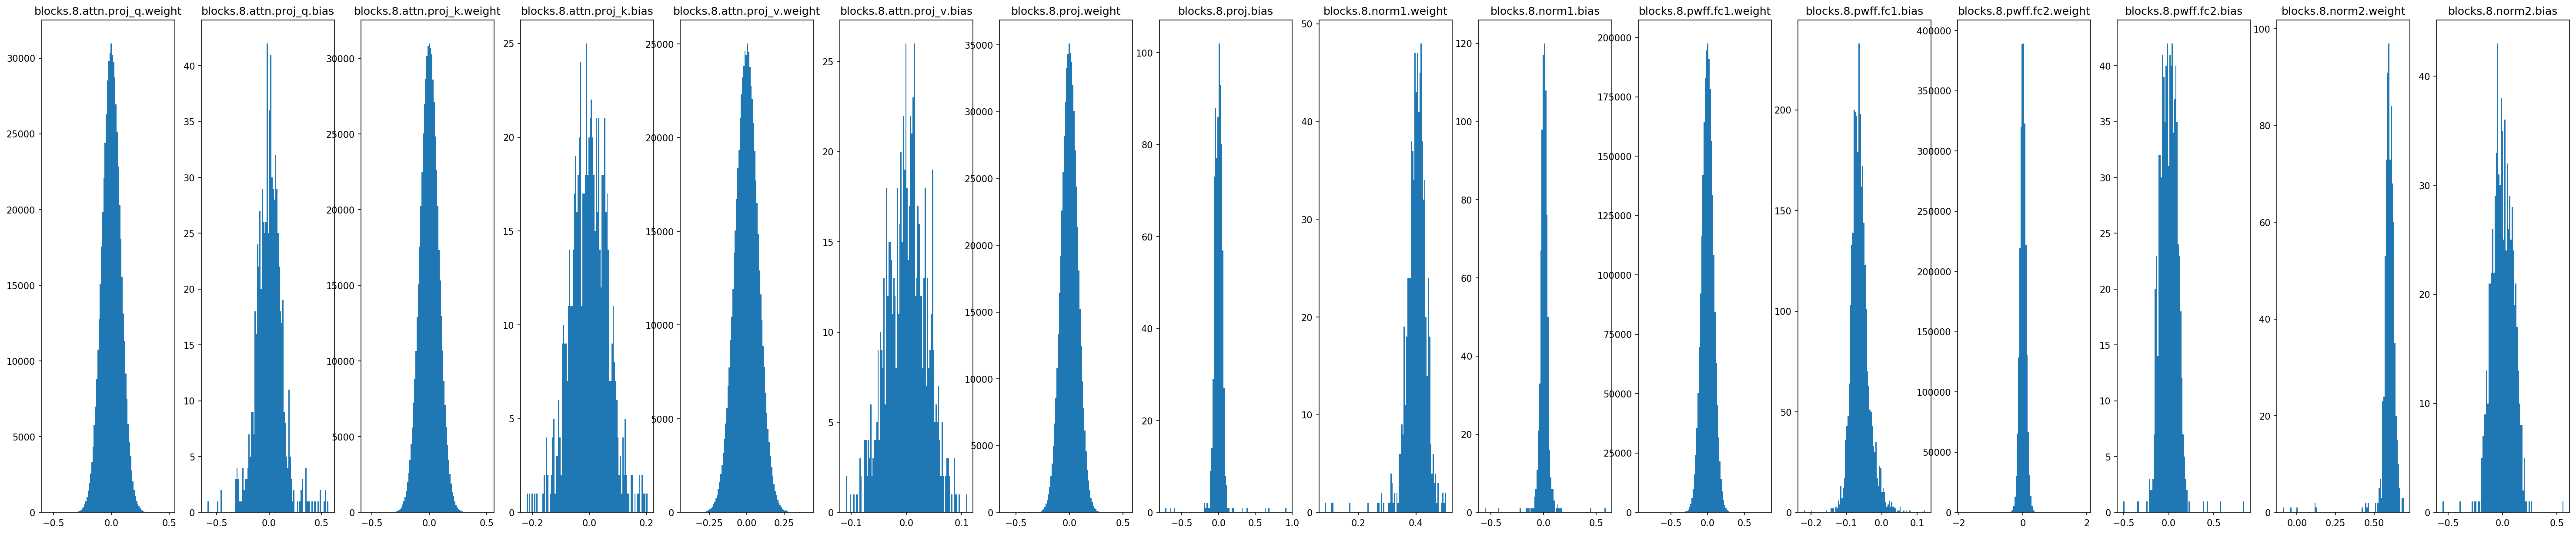

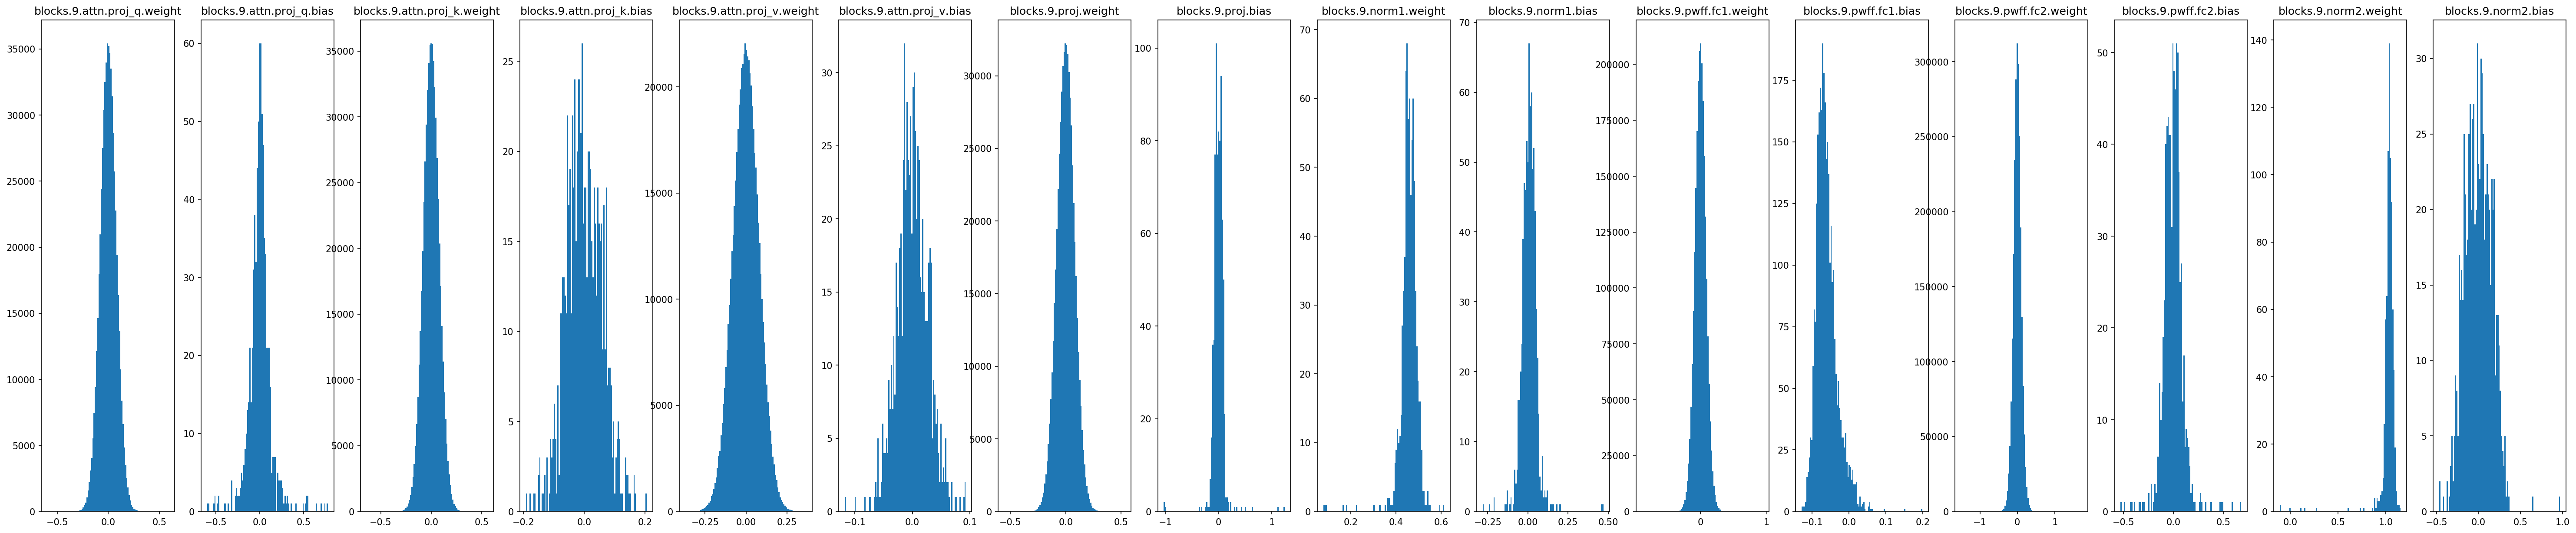

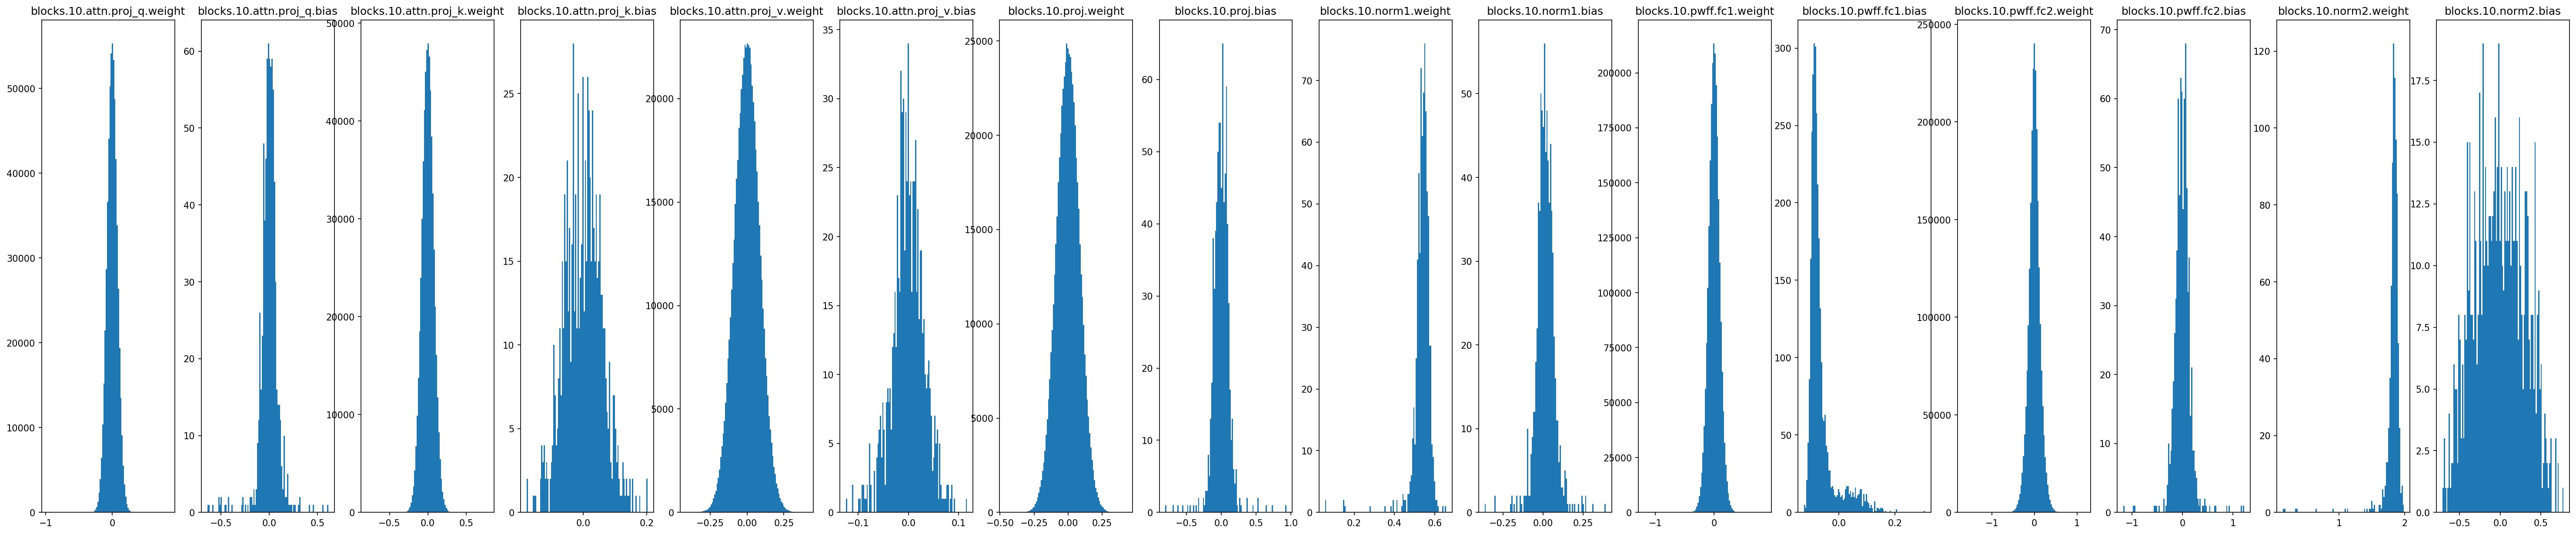

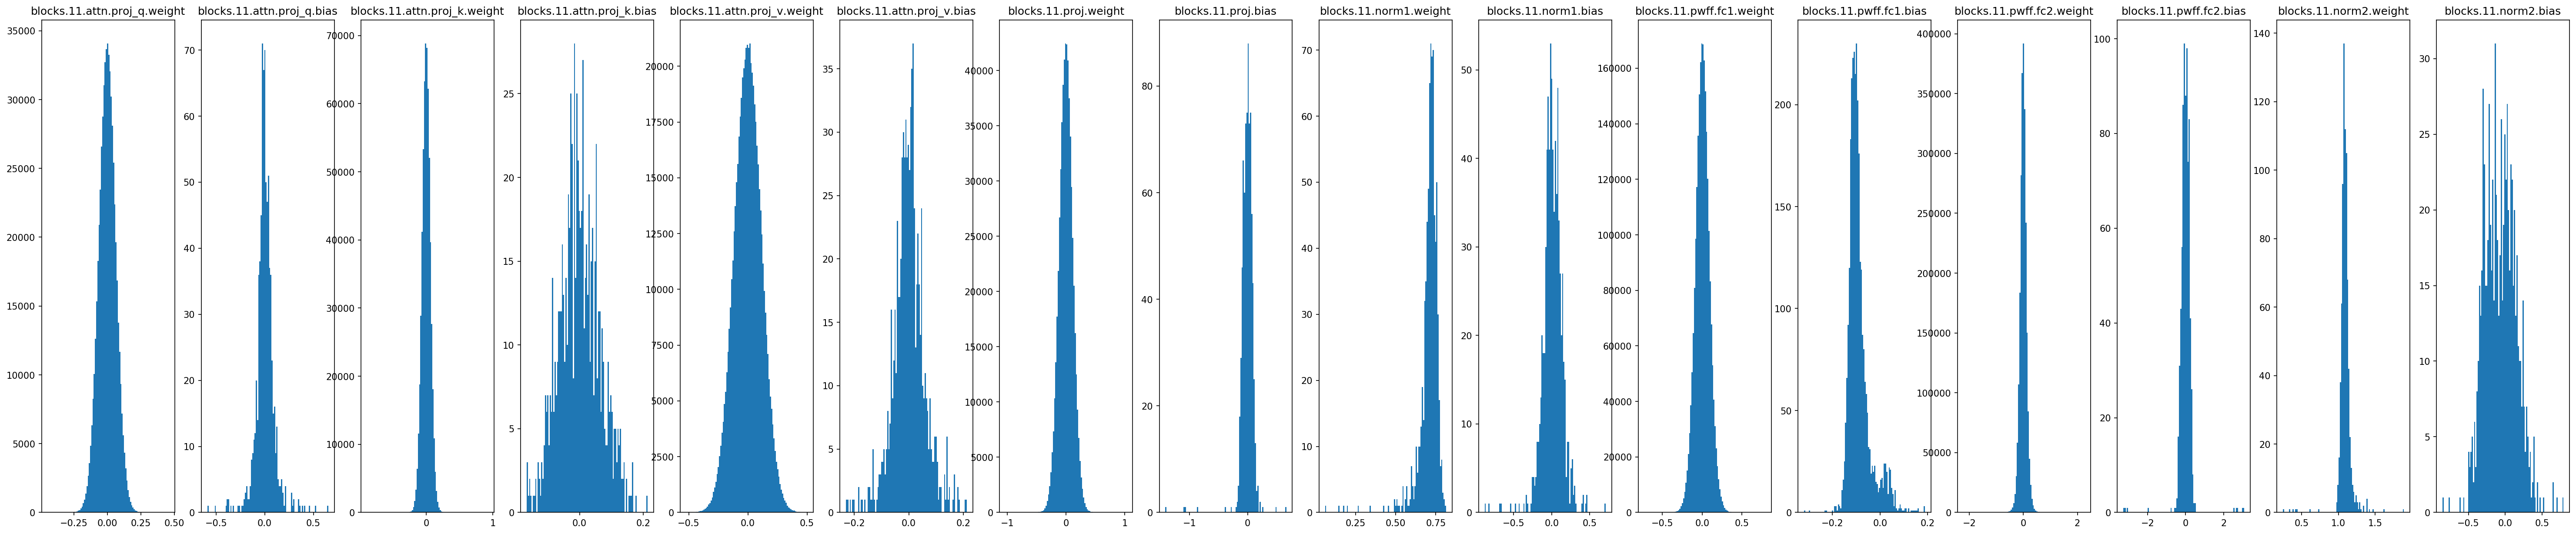

In [63]:
num = 12
for i in range(num):
    fig, axs = plt.subplots(1,len(parameter), figsize=(50,10), dpi=150)
    for ii in range(len(parameter)):
        param_ = parameter[ii].replace('0', str(i))
        axs[ii].hist(state_dict[param_].numpy().flatten(), bins = 100)
        axs[ii].set_title(param_.replace('transformer.',''))
    plt.show()